# Анализ окупаемости рекламы приложения Procrastinate Pro+. Проблемы и причины

## Описание проекта

В привлечение пользователей развлекательного приложения Procrastinate Pro+  были сделаны большите вложения. Однако последние несколько месяцев бизнес постоянно нес убытки. **Цель работы** - разобраться в причинах этой ситуации. 

Для этого нужно изучить, как люди пользуются продуктом, когда они начинают покупать, сколько денег приносит каждый клиент, когда он окупается и какие факторы отрицательно влияют на привлечение пользователей.

Данные в нашем распоряжении:
* посещения приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, 
* выгрузка их покупок за этот период, 
* статистика рекламных расходов.

**План работы:**
1. Создать пользовательские профили.
2. Изучить поведение пользователей в разрезе стран, устройств и каналов привлечения.
3. Проанализировать затраты на маркетинг, в том числе в разрезе источников привлечения.
4. Оценить окупаемость рекламы.

**Описание данных**:

Таблица visits_log_short (лог сервера с информацией о посещениях сайта):

    User Id — уникальный идентификатор пользователя
    Device — категория устройства пользователя
    Session start — дата и время начала сессии
    Session End — дата и время окончания сессии
    Channel — идентификатор рекламного источника, из которого пришел пользователь
    Region - страна пользователя

Таблица orders_log_short (информация о заказах):

    User Id — уникальный id пользователя, который сделал заказ
    Event Dt — дата и время покупки
    Revenue — выручка

Таблица costs_short (информация о затратах на маркетинг):

    Channel — идентификатор рекламного источника
    Dt — дата
    Costs — затраты на этот рекламный источник в этот день

## Загрузка данных и подготовка к анализу
Загрузим данные о визитах, заказах и расходах в переменные.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta

In [2]:
visits = pd.read_csv('datasets/visits_info_short.csv')
orders = pd.read_csv('datasets/orders_info_short.csv')
costs = pd.read_csv('datasets/costs_info_short.csv')

In [3]:
# создаём функцию для вывода инфо о столбцах датафрейма 
def describe_cols(dataframe):
    values = pd.DataFrame()
    
    for col in dataframe.columns:
        values[col] = [dataframe[col].unique(), dataframe[col].nunique()]
        
    return values.transpose().sort_values(by=1, ascending=True).rename(
        {0: 'Значения', 1: 'Кол-во уникальных значений'}, axis=1)

In [4]:
# создаём функцию для вывода инфо о датафрейме 
def df_info(dataframe):
    
    print('\033[1m' + 'Примеры строк датафрейма:' + '\033[0m')
    display(dataframe.sample(5))
    
    print('\033[1m' + 'Общая информация:' + '\033[0m')
    display(dataframe.info())
    
    _ = dataframe.duplicated().sum()
    print('\033[1m' + 'Явных дубликатов: ' + '\033[0m' + f'{_}.')
    print('\033[1m' + 'Доля дубликатов в датафрейме: ' + '\033[0m' + f'{round(_/len(dataframe) * 100, 2)}%.')
    print()
    
    print('\033[1m' + 'Количество пропусков в датафрейме:' + '\033[0m')
    display(pd.concat([dataframe.isna().sum(), dataframe.isna().mean()], axis=1) \
    .rename(columns={0:'кол-во', 1:'доля'}) \
    .style.format({'кол-во':'{:.0f}', 'доля':'{:.2%}'}))
    
    print('\033[1m' + 'Состав столбцов:' + '\033[0m')
    
    display(describe_cols(dataframe))
    
    print('\033[1m' + 'Статистические данные:' + '\033[0m')
    display(dataframe.describe())

In [5]:
df_info(visits)

Примеры строк датафрейма:


,User Id,Region,Device,Channel,Session Start,Session End
113283,580738803796,United States,iPhone,RocketSuperAds,2019-08-18 21:14:37,2019-08-18 21:33:18
109179,993847501112,United States,PC,FaceBoom,2019-08-15 12:26:03,2019-08-15 12:58:38
89035,221856999404,United States,PC,organic,2019-07-28 18:54:17,2019-07-28 19:43:50
193347,131797677511,United States,Mac,FaceBoom,2019-10-19 17:36:08,2019-10-19 17:49:59
46413,416225228361,United States,PC,FaceBoom,2019-06-18 07:47:27,2019-06-18 08:45:56


Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


None

Явных дубликатов: 0.
Доля дубликатов в датафрейме: 0.0%.

Количество пропусков в датафрейме:


,кол-во,доля
User Id,0,0.00%
Region,0,0.00%
Device,0,0.00%
Channel,0,0.00%
Session Start,0,0.00%
Session End,0,0.00%


Состав столбцов:


,Значения,Кол-во уникальных значений
Region,"[United States, UK, France, Germany]",4
Device,"[iPhone, Mac, Android, PC]",4
Channel,"[organic, TipTop, RocketSuperAds, YRabbit, Fac...",11
User Id,"[981449118918, 278965908054, 590706206550, 326...",150008
Session End,"[2019-05-01 02:45:01, 2019-05-01 04:47:35, 201...",306793
Session Start,"[2019-05-01 02:36:01, 2019-05-01 04:46:31, 201...",306813


Статистические данные:


,User Id
count,3.099010e+05
mean,4.997664e+11
std,2.887899e+11
min,5.993260e+05
25%,2.493691e+11
50%,4.989906e+11
75%,7.495211e+11
max,9.999996e+11


Пропусков в таблице нет, но нужно переделать тип данных в столбцах с временем начала и конца пользовательских сессий.

In [6]:
df_info(orders)

Примеры строк датафрейма:


,User Id,Event Dt,Revenue
18417,192173814184,2019-09-17 08:37:23,4.99
26763,150288180999,2019-10-26 21:04:30,4.99
37587,670990426064,2019-10-05 14:46:54,4.99
22613,86203516658,2019-10-07 01:30:44,4.99
10008,784328289169,2019-07-30 00:48:54,4.99


Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


None

Явных дубликатов: 0.
Доля дубликатов в датафрейме: 0.0%.

Количество пропусков в датафрейме:


,кол-во,доля
User Id,0,0.00%
Event Dt,0,0.00%
Revenue,0,0.00%


Состав столбцов:


,Значения,Кол-во уникальных значений
Revenue,"[4.99, 5.99, 9.99, 49.99, 19.99]",5
User Id,"[188246423999, 174361394180, 529610067795, 319...",8881
Event Dt,"[2019-05-01 23:09:52, 2019-05-01 12:24:04, 201...",40163


Статистические данные:


,User Id,Revenue
count,4.021200e+04,40212.000000
mean,4.990295e+11,5.370608
std,2.860937e+11,3.454208
min,5.993260e+05,4.990000
25%,2.511324e+11,4.990000
50%,4.982840e+11,4.990000
75%,7.433327e+11,4.990000
max,9.998954e+11,49.990000


Аналогично требует изменения тип данных в столбце Event Dt.


In [7]:
df_info(costs)

Примеры строк датафрейма:


,dt,Channel,costs
875,2019-10-03,YRabbit,6.480
502,2019-09-20,RocketSuperAds,8.125
430,2019-07-10,RocketSuperAds,10.465
440,2019-07-20,RocketSuperAds,10.010
212,2019-06-02,MediaTornado,3.600


Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


None

Явных дубликатов: 0.
Доля дубликатов в датафрейме: 0.0%.

Количество пропусков в датафрейме:


,кол-во,доля
dt,0,0.00%
Channel,0,0.00%
costs,0,0.00%


Состав столбцов:


,Значения,Кол-во уникальных значений
Channel,"[FaceBoom, MediaTornado, RocketSuperAds, TipTo...",10
dt,"[2019-05-01, 2019-05-02, 2019-05-03, 2019-05-0...",180
costs,"[113.3, 78.10000000000001, 85.80000000000001, ...",608


Статистические данные:


,costs
count,1800.000000
mean,58.609611
std,107.740223
min,0.800000
25%,6.495000
50%,12.285000
75%,33.600000
max,630.000000


И здесь нужно изменить тип данных в столбце с датой трат на маркетинг.

Кроме того, для удобства работы приведём названия столбцов во всех таблицах к единобразию, к "змеиному" стилю:

In [8]:
for df in [visits, orders, costs]:
    df.columns = df.columns.str.lower()
    df.rename(columns={'user id':'user_id', 'session start':'session_start', 'session end':'session_end', 'event dt':'event_dt'}, inplace=True)
    
    # проверяем результат переименования:
    display(df.sample())

,user_id,region,device,channel,session_start,session_end
246160,626268463235,Germany,PC,WahooNetBanner,2019-07-17 20:48:05,2019-07-17 21:10:17


,user_id,event_dt,revenue
33554,721996608048,2019-08-20 11:59:16,4.99


,dt,channel,costs
1295,2019-06-05,OppleCreativeMedia,13.25


Наконец, оптимизируем тип данных с датами:

In [9]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

# проверяем результат изменений:
visits.info()
orders.info()
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.

**Итог:**

В ходе преобработки данных было сделано следующее:
- оптимизированы названия колонок датареймов,
- изменён тип данных в столбцах с датами на корректный,
- исключены дубликаты.

## Создание функций для анализа бизнес-показателей

В этом блоке создаём необходимые функции для расчета и анализа следующих бизнес-показателей:
* LTV (Lifetime Value, пожизненная ценность), 
* ROI (Return On Investment, окупаемость инвестиций), 
* Retention Rate (коэффициент удержания)
* Conversion Rate (коэффициент конверсии).

### Функция для создания пользовательских профилей 

In [10]:
def get_profiles(visits, orders):
    
    # находим параметры первых посещений
    profiles = (
        visits.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )
    
    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
    
    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())
    
    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
        )
    
    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = round(ad_costs['costs'] / ad_costs['unique_users'] , 2)

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
        )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)
    
    return profiles

### Функция для сглаживания фрейма

In [11]:
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

### Функция для расчёта LTV и ROI

In [12]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
    ):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

### Функция для визуализации LTV и ROI

In [13]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

### Функция для расчёта удержания

In [14]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
    ):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

### Функция для визуализации удержания

In [15]:
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

### Функция для расчёта конверсии

In [16]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
    ):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

### Функция для визуализации конверсии

In [17]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

## Исследовательский анализ данных

В этом разделе выясним:
- Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?
- Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?
- По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?


### Пользовательские профили

In [18]:
# создаём пользовательские профили
profiles = get_profiles(visits, orders)
profiles.sample(10)

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
121349,809019718449,2019-10-11 08:42:40,organic,Android,UK,2019-10-11,2019-10-01,False,0.00
41931,278027677144,2019-09-02 20:31:31,WahooNetBanner,Android,France,2019-09-02,2019-09-01,False,0.57
5553,37205137845,2019-10-26 08:40:27,FaceBoom,iPhone,United States,2019-10-26,2019-10-01,False,1.11
42297,280464902876,2019-10-23 14:26:12,FaceBoom,Android,United States,2019-10-23,2019-10-01,False,1.12
55107,366164361337,2019-08-11 04:13:27,organic,iPhone,United States,2019-08-11,2019-08-01,False,0.00
31792,211147764263,2019-08-21 00:30:19,lambdaMediaAds,PC,Germany,2019-08-21,2019-08-01,False,0.80
142966,954063488066,2019-08-19 11:18:22,FaceBoom,PC,United States,2019-08-19,2019-08-01,False,1.11
12914,85650878197,2019-08-11 12:54:12,organic,iPhone,United States,2019-08-11,2019-08-01,False,0.00
25185,168008774179,2019-08-31 21:21:09,TipTop,iPhone,United States,2019-08-31,2019-08-01,False,3.02
60519,401403576849,2019-05-18 01:50:56,organic,Android,United States,2019-05-18,2019-05-01,False,0.00


In [19]:
profiles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150008 entries, 0 to 150007
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   user_id           150008 non-null  int64         
 1   first_ts          150008 non-null  datetime64[ns]
 2   channel           150008 non-null  object        
 3   device            150008 non-null  object        
 4   region            150008 non-null  object        
 5   dt                150008 non-null  object        
 6   month             150008 non-null  datetime64[ns]
 7   payer             150008 non-null  bool          
 8   acquisition_cost  150008 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(1), int64(1), object(4)
memory usage: 10.4+ MB


In [20]:
# Определим минимальную и максимальную дату привлечения пользователей.
print('Даты привлечения пользователей: минимальная - {}, максимальная - {}'.format(min(profiles['dt']), max(profiles['dt'])))

Даты привлечения пользователей: минимальная - 2019-05-01, максимальная - 2019-10-27


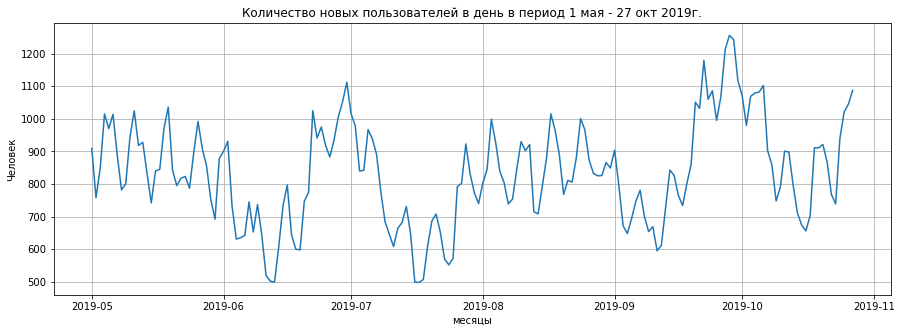

In [21]:
profiles.groupby('dt').agg({'user_id': 'nunique'}).plot(
    figsize=(15,5),
    title='Количество новых пользователей в день в период 1 мая - 27 окт 2019г.', 
    ylabel='Человек',
    xlabel='месяцы',
    legend=False,
    grid=True
)

plt.show()

Видим, что за период с 1 мая по 27 октября всего было привлечено чуть больше 150 тыс. пользователей. Прослеживается некая сезонность в привлечении, но в целом можно сказать, что за эти полгода каждый день привлекалось в среднем по 800-900 пользователей в день. Эта стабильность говорит о том, что причина убытков далеко не в том, что бизнес стал привлекать меньше новых пользователей.

### География пользователей

 Выясним, из каких стран приходят посетители и какие страны дают больше всего платящих пользователей.

In [22]:
# выведем количество пользователей и долю платящих пользоваталей из каждой страны
country_profiles = (
    profiles.groupby('region')
    .agg(
        {
            'user_id':'nunique', 
            'payer':'mean'
        }
        )
    .rename(columns={
        'user_id':'users', 
        'payer':'payer_share'}
           )
     .sort_values(by='payer_share', ascending=False)
                   )

#отобразим долю платящих пользователей в процентах
country_profiles['payer_share, %'] = round(country_profiles['payer_share'] * 100, 1)

country_profiles[['users', 'payer_share, %']]

,users,"payer_share, %"
region,,
United States,100002,6.9
Germany,14981,4.1
UK,17575,4.0
France,17450,3.8


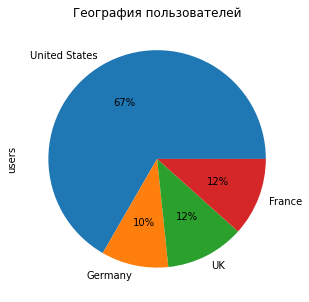

In [23]:
# визулизируем из каких стран приходят пользователи
country_profiles.plot(
    kind='pie',
    y='users',
    figsize=(5, 5),
    title='География пользователей',
    autopct='%1.f%%',
    legend=False
)
plt.show()

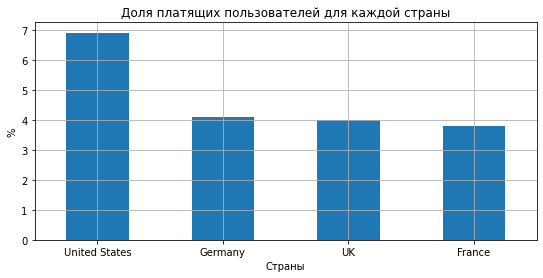

In [24]:
# визуализируем доли платящих пользователей
country_profiles.plot(
    kind='bar',
    y='payer_share, %',
    rot=0,
    title='Доля платящих пользователей для каждой страны', 
    ylabel='%',
    xlabel='Страны',
    legend=False,
    figsize=(9, 4),
    grid=True
)

plt.show()

Пользователи приложения приходят из 4 стран: США, Германии, Великобритании и Франции. Две трети всех пришедших за рассматриваемый период пользователей (больше 100 тыс. из 150 тыс.) живут в США, и в этой же стране (по сравнению с другими) самая большая доля платящих пользователей: почти 7%,   тогда как в Германии, Великобритании и Франции эти доли равны плюс-минус 4%.

### Устройства пользователей

Далее рассмотрим, с каких устройств впервые зашли в приложение пользователей и какие девайсы предпочитают платящие клиенты.

In [25]:
device_profiles = profiles.groupby('device')\
    .agg(
        {
            'user_id':'nunique', 
            'payer':'mean'
        }
        )\
    .rename(columns={
        'user_id':'users', 
        'payer':'payer_share'}
           )\
     .sort_values(by='payer_share', ascending=False)

#отобразим долю платящих пользователей в процентах
device_profiles['payer_share, %'] = round(device_profiles['payer_share'] * 100, 1)

device_profiles[['users', 'payer_share, %']]

,users,"payer_share, %"
device,,
Mac,30042,6.4
iPhone,54479,6.2
Android,35032,5.9
PC,30455,5.0


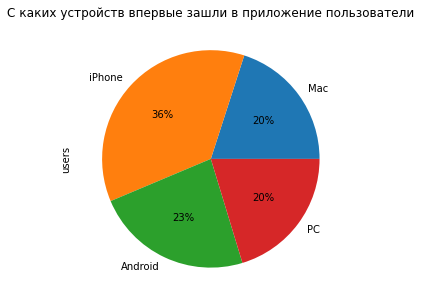

In [26]:
# визулизируем какими устройствами пользуются клиенты
device_profiles.plot(
    kind='pie',
    y='users',
    figsize=(5, 5),
    title='С каких устройств впервые зашли в приложение пользователи',
    autopct='%1.f%%',
    legend=False
)
plt.show()

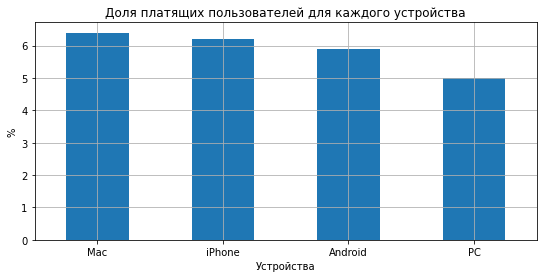

In [27]:
# изучим какие устройства предпочитают платящие пользователи
device_profiles.plot(
    kind='bar',
    y='payer_share, %',
    rot=0,
    title='Доля платящих пользователей для каждого устройства', 
    ylabel='%',
    xlabel='Устройства',
    legend=False,
    figsize=(9, 4),
    grid=True
)

plt.show()

Больше половины пользователей (59%) зашли впервые в приложение с мобильных устройства (из них 36% - с Iphone, остальные - с Android), однако среди платящих пользователей больше всего популярны компьютеры с MacOS, доля платящих пользователей для этих устройств 6,4%. Меньше всего желают платить пользователи PC.

Также рассмотрим, есть ли существенное различие в пропорциях владельцев различных устройств по странам.

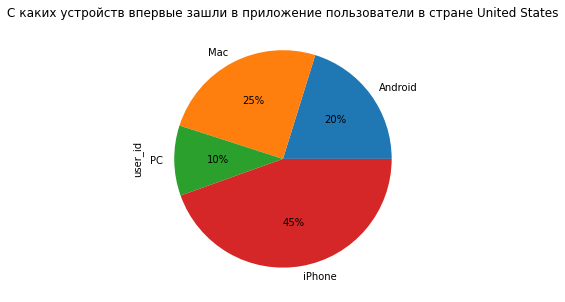

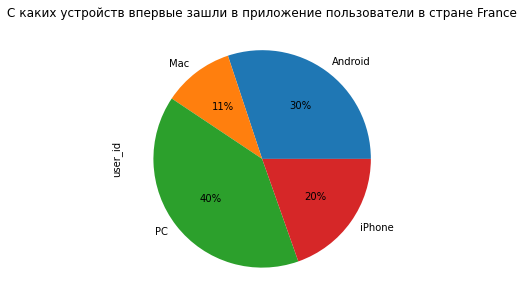

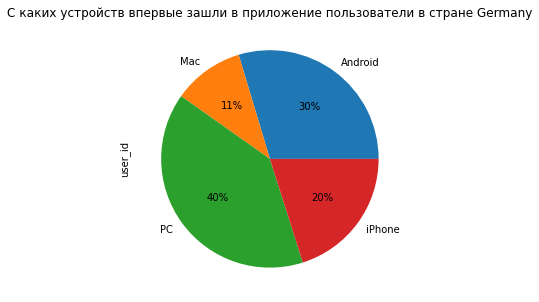

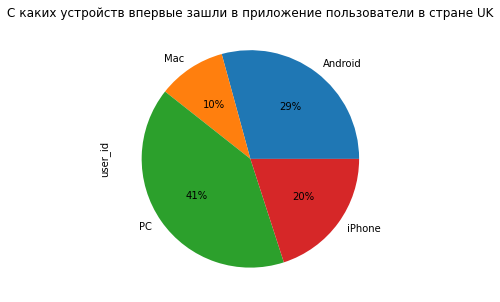

In [28]:
regions = list(profiles['region'].unique())
for country in regions:
    profiles[profiles['region'] == country]\
    .groupby('device')['user_id'].nunique()\
    .plot(
    kind='pie',
    y='user_id',
    figsize=(5, 5),
    title=f'С каких устройств впервые зашли в приложение пользователи в стране {country}',
    autopct='%1.f%%',
    legend=False
    )
    plt.show()

По данным графикам легко прослеживается следующая тенденция: пользователи Штатов предпочитают больше устройства Iphone и Mac, а вот жители Европы почти едины даже в долях владения устройствами, и явно предпочитают заходить в приложение через PC или Android.

### Каналы привлечения пользователей

Теперь изучим, по каким рекламным каналам шло привлечение пользователей. И какие каналы принесли больше всего платящих пользователей.

In [29]:
channel_profiles = profiles.groupby('channel')\
    .agg(
        {
            'user_id':'nunique', 
            'payer':'mean'
        }
        )\
    .rename(columns={
        'user_id':'users', 
        'payer':'payer_share'}
           )\
     .sort_values(by='payer_share', ascending=False)

#отобразим долю платящих пользователей в процентах
channel_profiles['payer_share, %'] = round(channel_profiles['payer_share'] * 100, 1)

channel_profiles[['users', 'payer_share, %']]

,users,"payer_share, %"
channel,,
FaceBoom,29144,12.2
AdNonSense,3880,11.3
lambdaMediaAds,2149,10.5
TipTop,19561,9.6
RocketSuperAds,4448,7.9
WahooNetBanner,8553,5.3
YRabbit,4312,3.8
MediaTornado,4364,3.6
LeapBob,8553,3.1


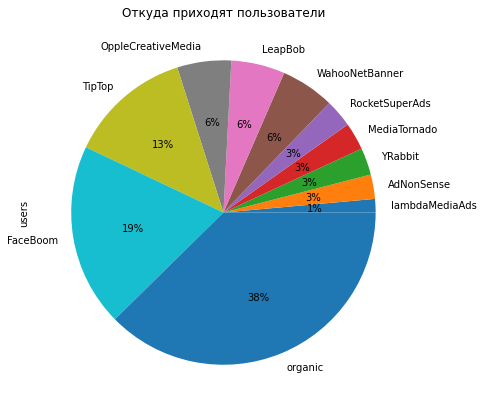

In [30]:
# визулизируем каналы, откуда приходят клиенты
channel_profiles.sort_values('users').plot(
    kind='pie',
    y='users',
    figsize=(7, 7),
    title='Откуда приходят пользователи',
    autopct='%1.f%%',
    legend=False
)
plt.show()

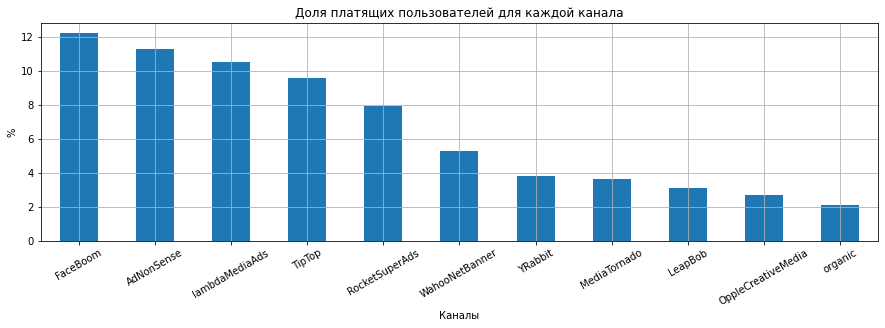

In [31]:
# визуализируем, откуда пришли платящие пользователи
channel_profiles.plot(
    kind='bar',
    y='payer_share, %',
    rot=30,
    title='Доля платящих пользователей для каждой канала', 
    ylabel='%',
    xlabel='Каналы',
    legend=False,
    figsize=(15, 4),
    grid=True
)

plt.show()

Больше всего в приложение попадают "органические" пользователи, которые самостоятельно находят приложение. Однако среди них меньше всего платящих пользователей. 

Если не рассматривать органиков, а только рекламные источники привлечения, то здесь лидером является Faceboom - оттуда приходят почти одна пятая всех пользователей, и это источник с самой большой долей платящих пользователей (12,2%). 

С каналов AdNonSense и lambdaMediaAds приходит меньше всего пользователей, однако качество этой аудитории также на высоком уровне - 10-11 человек из ста, привлечённых с этих каналов, готовы платить за услуги нашего бизнеса.

Но при анализе рекламных источников вызывает вопрос канал TipTop - он занимает второе место по количеству привлечённых пользователей в рассматриваемый период, однако доля платящей аудитории с этого канала составляет 9,6% - для такого большого источника качество аудитории оставляет желать лучшего. Причём судя по динамике доли платящих пользователей за последние полгода качество аудитории канала TipTop имеет тенденцию к снижению.

## Маркетинг

В этом разделе ответим на вопросы:
- Сколько денег потратили: всего / на каждый источник / в динамике по времени ?
- Сколько в среднем стоило привлечение одного покупателя из каждого источника (CAC)?

### Расходы на маркетинг

Посчитаем общую сумму расходов на маркетинг, а также рассмотрим, как траты распределены по рекламным каналам привлечения пользователей.

In [32]:
print('В период с 1 мая по 27 окт. 2019г. на маркетинг было потрачено: {} ден.ед.'.format(costs['costs'].sum().astype('int')))
print('Распределение по источникам: ')
costs_by_channel = costs.groupby('channel').agg({'costs':'sum'}).sort_values(by='costs', ascending=False)
costs_by_channel

В период с 1 мая по 27 окт. 2019г. на маркетинг было потрачено: 105497 ден.ед.
Распределение по источникам: 


,costs
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


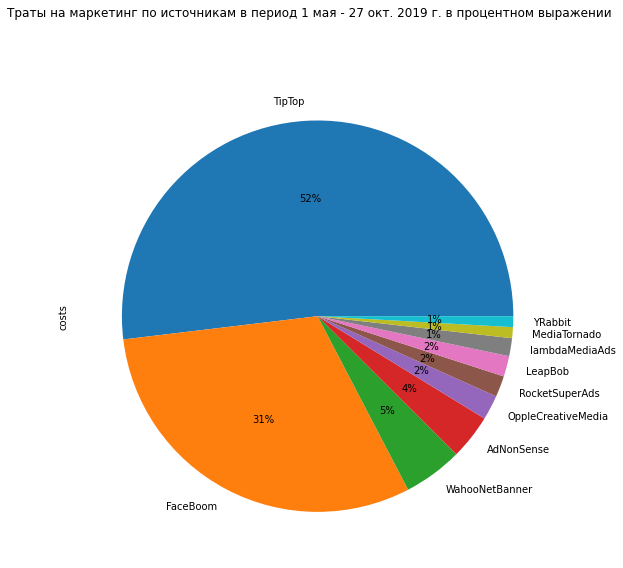

In [33]:
# визуализируем распределение по каналам
costs_by_channel.plot.pie(
    subplots=True, 
    figsize=(9, 9), 
    autopct='%1.f%%', 
    legend=False,
    title='Траты на маркетинг по источникам в период 1 мая - 27 окт. 2019 г. в процентном выражении')

plt.show()

Среди всех источников выделяются два самых популярных: TipTop, куда ушло больше половины всех затрат на маркетинг, и FaceBoom, забравший на себя 31% бюджета. 
Остальные 17% маркетинговых затрат приходятся на 8 источников, каждый из которых забрал от 1 до 5% общих трат.

При этом, как мы ранее выяснили, в рейтинге по качеству аудитории FaceBoom занимает 1 место, а TipTop только четвёртое. Поэтому такие большие затраты на TipTop настораживают.

Рассмотрим, менялись ли затраты по источникам во времени в отчётном периоде.
Для удобства анализа выделим мелкие по затратам источники в отдельную группу и рассмотрим динамику затрат на источники этой группы, затем динамику затрат на двух рекламных "гигантов" в лице TipTop и FaceBoom.

In [34]:
channels_min_costs = list(costs_by_channel.tail(8).index)
channels_min_costs

['WahooNetBanner',
 'AdNonSense',
 'OppleCreativeMedia',
 'RocketSuperAds',
 'LeapBob',
 'lambdaMediaAds',
 'MediaTornado',
 'YRabbit']

In [35]:
# добавим столбец с месяцем в датафрейм с затратами
costs['month'] = costs['dt'].astype('datetime64[M]')
costs.head(1)

,dt,channel,costs,month
0,2019-05-01,FaceBoom,113.3,2019-05-01


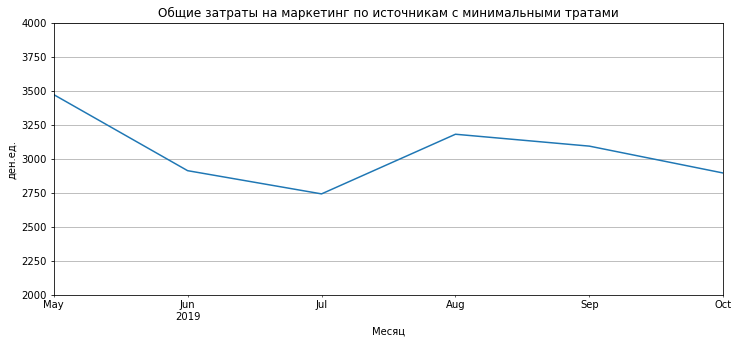

In [36]:
costs.query('channel in @channels_min_costs ')\
.groupby('month').agg({'costs':'sum'})\
.plot(
    title = 'Общие затраты на маркетинг по источникам с минимальными тратами',
    xlabel='Месяц',
    ylabel='ден.ед.',
    grid=True,
    figsize=(12, 5),
    ylim=(2000, 4000),
    legend=False
)

plt.show()

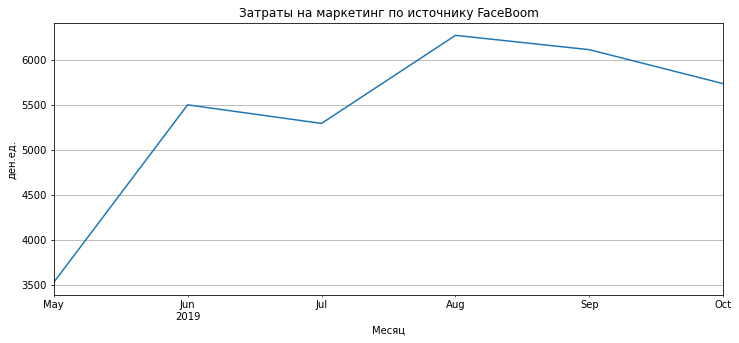

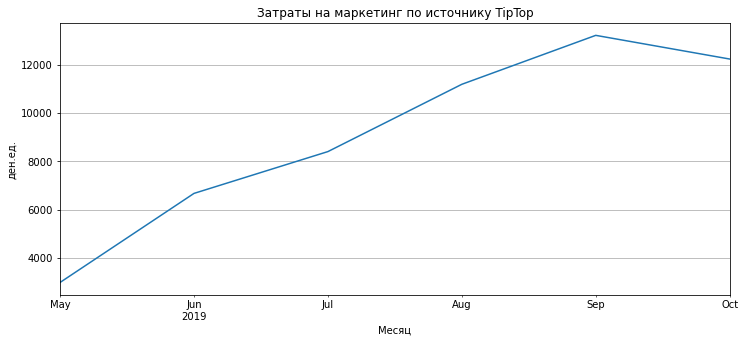

In [37]:
for channel in ['FaceBoom', 'TipTop']:
    costs[costs['channel'] == channel]\
    .groupby('month').agg({'costs':'sum'})\
    .plot(
        title = 'Затраты на маркетинг по источнику {}'.format(channel),
        xlabel='Месяц',
        ylabel='ден.ед.',
        grid=True,
        figsize=(12, 5),
#         ylim=(3000, 7000),
        legend=False
    )

    plt.show()

По динамике видно, что траты на два самых крупных рекламных канала (TipTop и FaceBoom) имеют усточивую тенденцию к росту, тогда как суммарные траты на мелкие каналы варьируются в пределах одного диапазона в среднем по 3200 ден.ед. в месяц.

У нас нет полных данных за последний месяц октябрь, однако видно, что затраты на Faceboom за отчетный период выросли почти в 2 раза (с 3500 до 6400 ден.ед.), а затраты на TipTop возросли более чем в 4 раза (с 3 тыс. до почти 14 тыс. ден.ед.).
Таким образом, канал TipTop заставляет обратить на себя всё большее внимание в дальнейшем анализе.

### Стоимость привлечения пользователя

Узнаем, сколько в среднем стоило привлечение одного пользователя из каждого источника. Рассчитаем средний CAC на одного пользователя для всего проекта и для каждого источника трафика.

**Средний CAC за отчётный период по всем источникам**

In [38]:
# исключаем "органических" пользователей
profiles_without_organic = profiles.query('channel != "organic"')

print('Средний CAC за отчётный период по всем источникам равен: {} ден.ед.'.format(
    round(profiles_without_organic['acquisition_cost'].mean(), 2)))

Средний CAC за отчётный период по всем источникам равен: 1.13 ден.ед.


**Средний CAC за отчётный период по всем источникам в динамике**

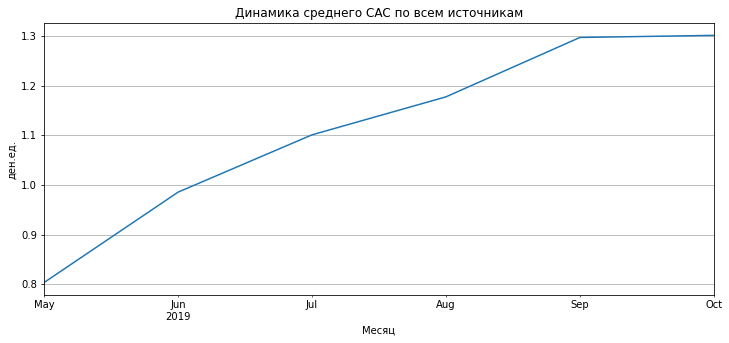

In [39]:
profiles_without_organic\
    .groupby('month')['acquisition_cost'].mean()\
    .plot(
    figsize=(12, 5),
    grid=True,
    title='Динамика среднего CAC по всем источникам',
    xlabel='Месяц',
    ylabel='ден.ед.'
    )

plt.show()

С каждым месяцем стоимость привлечения клиентов возрастает. Т.к. CAC - один из факторов влияния на ROI, то возрастающий от месяца к месяцу CAC вполне может быть причиной убытков нашего бизнеса.

Рассмотрим детальнее, каких источников касается возрастающая соимость привлечения.

**Средний CAC за отчётный период по каждому из источников**

In [40]:
cac = (
    profiles.groupby('channel')
    .agg({'acquisition_cost':'mean'})
    .rename(columns={'acquisition_cost': 'cac'})
    .sort_values(by='cac', ascending=False)
)
cac

,cac
channel,
TipTop,2.799018
FaceBoom,1.113515
AdNonSense,1.007521
lambdaMediaAds,0.724709
WahooNetBanner,0.602102
RocketSuperAds,0.411594
OppleCreativeMedia,0.250402
MediaTornado,0.218682
YRabbit,0.218650


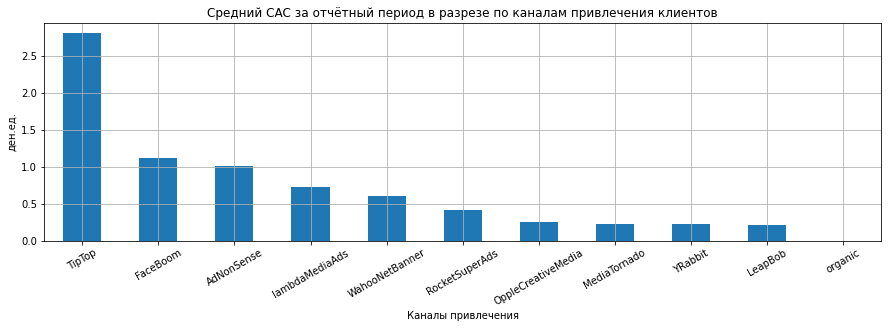

In [41]:
cac.plot(
    kind='bar',
    rot=30,
    title='Средний CAC за отчётный период в разрезе по каналам привлечения клиентов', 
    ylabel='ден.ед.',
    xlabel='Каналы привлечения',
    legend=False,
    figsize=(15, 4),
    grid=True
)

plt.show()

За рассматриваемый период дороже всего бизнесу обошлись клиенты, привлечённые с каналов TipTop и FaceBoom. Это два самых популярных рекламных канала, которые и обходятся дороже всех. Однако, CAС канала TipTop (2,8 ден.ед.) выглядит зашкаливающим на фоне остальных каналов, чей CAC лежит в диапазоне 0,2-1,1 ден.ед.

**Динамика CAC**

Рассмотрим, как менялась в динамике средняя стоимость привлечения клиента у двух самых крупных каналов(TipTop и FaceBoom) и у остальной группы каналов.

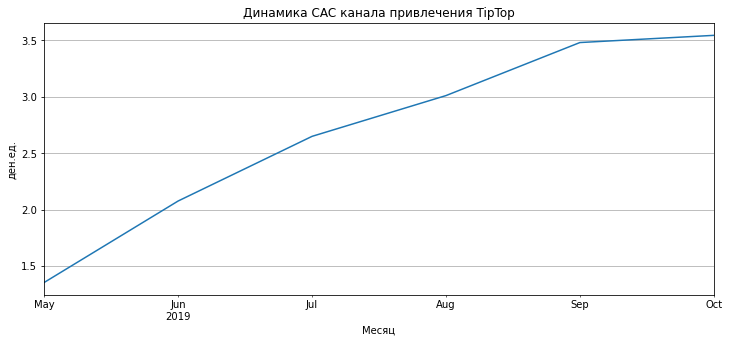

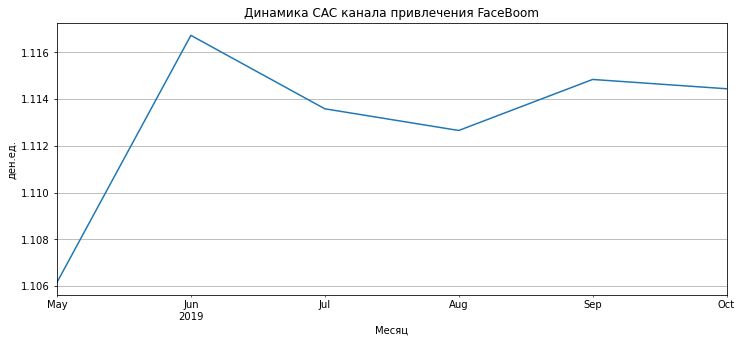

In [42]:
for channel in ['TipTop', 'FaceBoom']:
    profiles[profiles['channel'] == channel]\
    .groupby('month')['acquisition_cost'].mean()\
    .plot(
        figsize=(12, 5),
        grid=True,
        title='Динамика CAC канала привлечения {}'.format(channel),
        xlabel='Месяц',
        ylabel='ден.ед.'
    )

    plt.show()

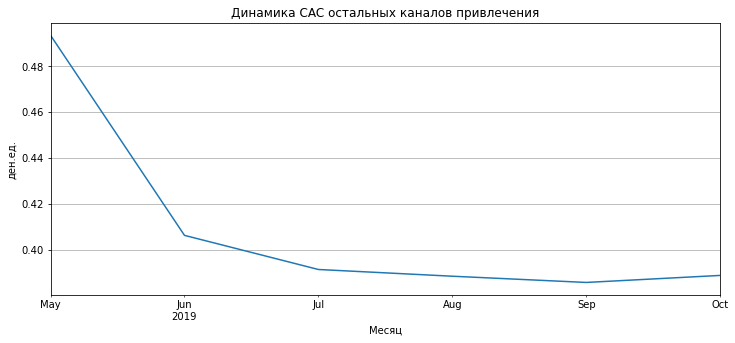

In [43]:
profiles.query('channel in @channels_min_costs')\
.groupby('month')['acquisition_cost'].mean()\
.plot(
    figsize=(12, 5),
    grid=True,
    title='Динамика CAC остальных каналов привлечения',
    xlabel='Месяц',
    ylabel='ден.ед.'
)

plt.show()

По динамике видно, что у всех каналов кроме TipTop колебания среднего САС можно обозначить как легкие, потому что они находятся в диапазоне менее чем 1 ден.ед. на протяжении всего отчетного периода.

При этом средний САС канала TipTop всегда только увеличивается: каждые 2 месяца можно наблюдать повышение примерно на 1 ден.ед. Проверим, с какими факторами это связано, взглянув на динамику ежемесячных расходов на этот канал, а также на количество привлечённых людей с этого канала.

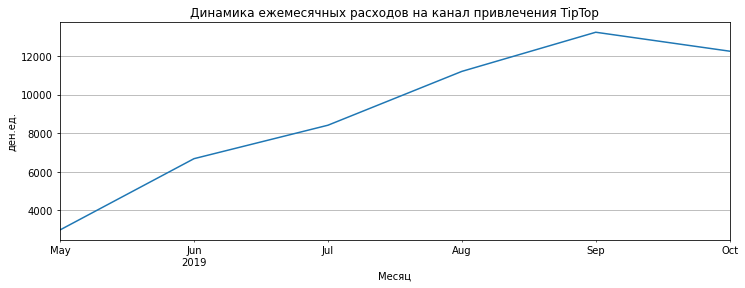

In [44]:
costs.query('channel == "TipTop"')\
.groupby('month')['costs'].sum()\
.plot(
    figsize=(12, 4),
    grid=True,
    title='Динамика ежемесячных расходов на канал привлечения TipTop',
    xlabel='Месяц',
    ylabel='ден.ед.'
)

plt.show()

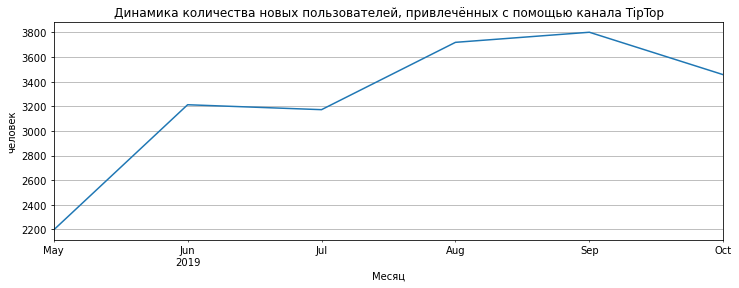

In [45]:
profiles.query('channel == "TipTop"')\
.groupby('month')['user_id'].nunique()\
.plot(
    figsize=(12, 4),
    grid=True,
    title='Динамика количества новых пользователей, привлечённых с помощью канала TipTop',
    xlabel='Месяц',
    ylabel='человек'
)

plt.show()

И расходы на Tiptop, и количество пришедших оттуда пользователей  имеют тенденцию расти, однако видно, что даже когда в июле количество новых пользователей уменьшилось по сравнению с прошлым месяцем - расходы за этот период не уменьшились, а только увелились. Значит темпы роста расходов на TipTop превышали темпы роста пользователей оттуда.  А значит, рекламный трафик в TipTop'e действительно дорожал. 

## Оценка окупаемости рекламы для привлечения пользователей

В этом разделе с помощью LTV и ROI:
- Проанализируем общую окупаемость рекламы;
- Для детального понимания проанализируем окупаемость рекламы с разбивкой по рекламным каналам, странам и устройствам.

В ходе исследования, ответим на вопросы:
- Окупается ли реклама, направленная на привлечение пользователей в целом? 
- Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
- Изучим конверсию и удержание для понимания проблемы окупаемости.

### Общая окупаемость рекламы

Установим момент и горизонт анализа данных. По условию на календаре 1 ноября 2019 года, это и будет моментом анализа. И зададим 2-хнедельный горизонт анализа, т.к. в бизнес-плане  заложено, что пользователи должны окупаться не позднее чем через 2 недели.

И исключим из расчётов органических пользователей, т.к. мы за их привлечение ничего не платим. Всю оценку окупаемости рекламы для привлечения пользователей рассчитаем по пользователям, пришедшим с платныx рекламныx каналов.  

In [46]:
observation_date = datetime(2019, 11, 1).date()
horizon_days = 14
profiles = profiles.query('channel != "organic"')

In [47]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
    )

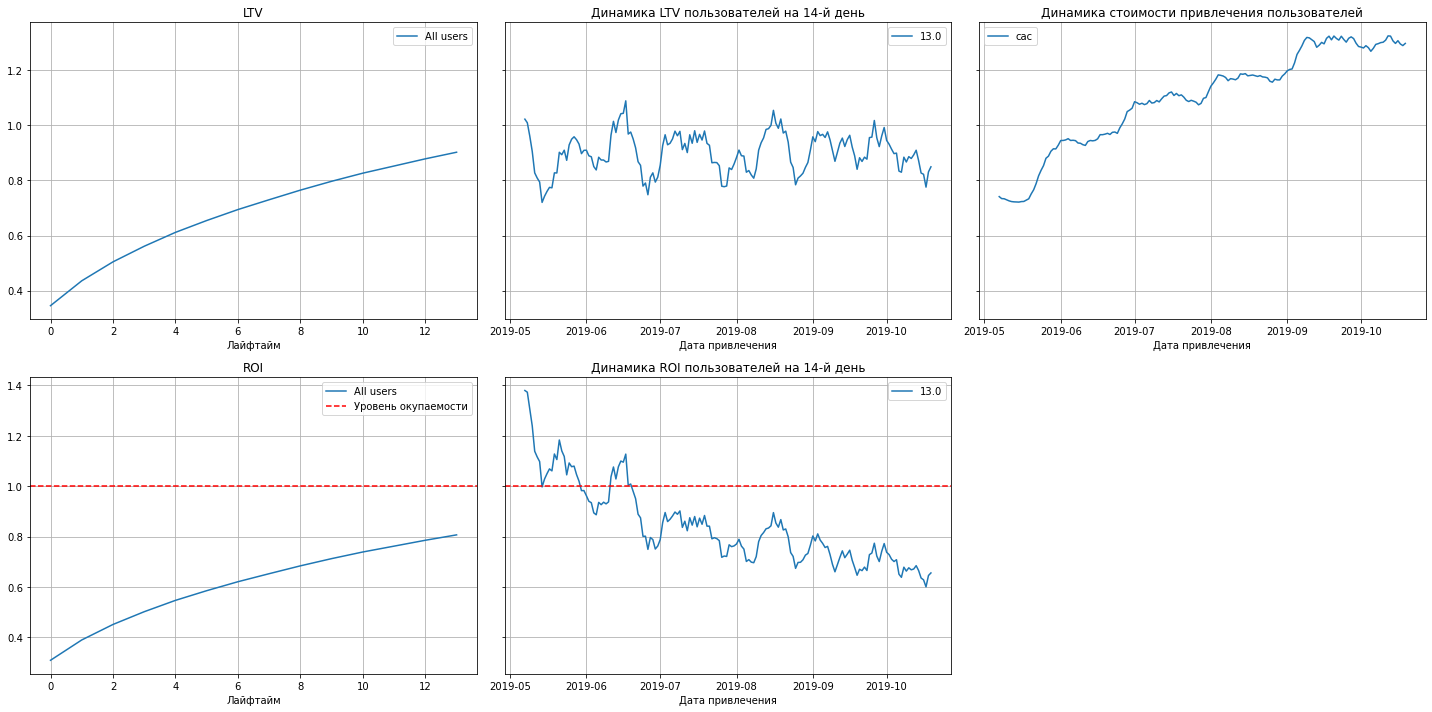

In [48]:
# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

По графикам можно сделать такие выводы:

- Реклама не окупается. В среднем ROI спустя 2 недели едва превышает 80% , что говорит об убытках. Причём до июня реклама ещё окупалась, но отрицательная динамика привела к систематическому снижению ROI.
- к июню CAС претерпел довольно резкий скачок (с 0,7 до 0,95 ден.ед.) и с тех пор сохраняет тенденцию к увеличению.
- в динамике LTV видна некоторая сезонность, но показатель достаточно стабилен и в среднем держится около 0,9 ден.ед. Значит, вряд ли дело в ухудшении качества пользователей.

Видно, что до июня реклама окупалась порой почти на 140%, но после роста CAC в июне - ROI резко упал. А после дальнейшего увеличения CAC при сохранении прежнего уровня LTV  видим, как результат, снижение ROI и неокупаемость трат на маркетинг.

Чтобы разобраться в деталях, пройдём по всем доступным характеристикам пользователей — источнику привлечения, стране и устройству первого посещения.

### Окупаемость рекламы с разбивкой по рекламным каналам

Начнём с разбивки по рекламным каналам, изучим окупаемость рекламы каждого источника.

Т.к. у нас 10 каналов привлечения клиентов, то для удобства анализа по графикам разобьём их на 3 группы: от самых дорогих до самых бюджетных. За основу возьмём рейтинг каналов по убыванию среднего CAC.

In [49]:
channels_list = list(cac.index)
channels_list

['TipTop',
 'FaceBoom',
 'AdNonSense',
 'lambdaMediaAds',
 'WahooNetBanner',
 'RocketSuperAds',
 'OppleCreativeMedia',
 'MediaTornado',
 'YRabbit',
 'LeapBob',
 'organic']

In [50]:
# убираем канал organic, т.к. нет затрат на привлечение органических пользователей
channels_list = channels_list[0:-1]
channels_list

['TipTop',
 'FaceBoom',
 'AdNonSense',
 'lambdaMediaAds',
 'WahooNetBanner',
 'RocketSuperAds',
 'OppleCreativeMedia',
 'MediaTornado',
 'YRabbit',
 'LeapBob']

In [51]:
# формируем 3 группы каналов
channels_list_1 = channels_list[0:3]
channels_list_2 = channels_list[3:6]
channels_list_3 = channels_list[6:10]

In [52]:
# выделяем соответствующие группы пользовательских профилей
filtered_1_profiles = profiles.query('channel in @channels_list_1')
filtered_2_profiles = profiles.query('channel in @channels_list_2')
filtered_3_profiles = profiles.query('channel in @channels_list_3')

Окупаемость рекламы с разбивкой по каналам привлечения группы № 1


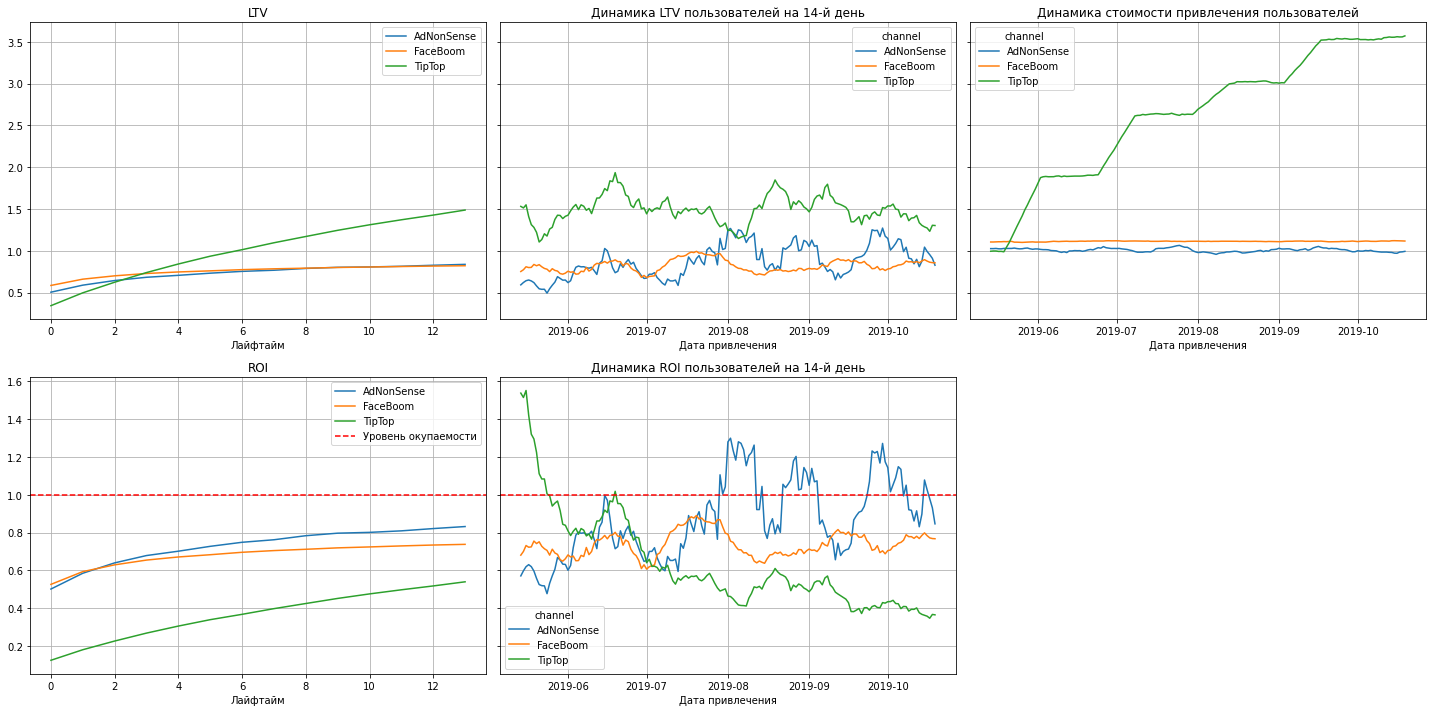

-------------------------------------------------------------------------------
Окупаемость рекламы с разбивкой по каналам привлечения группы № 2


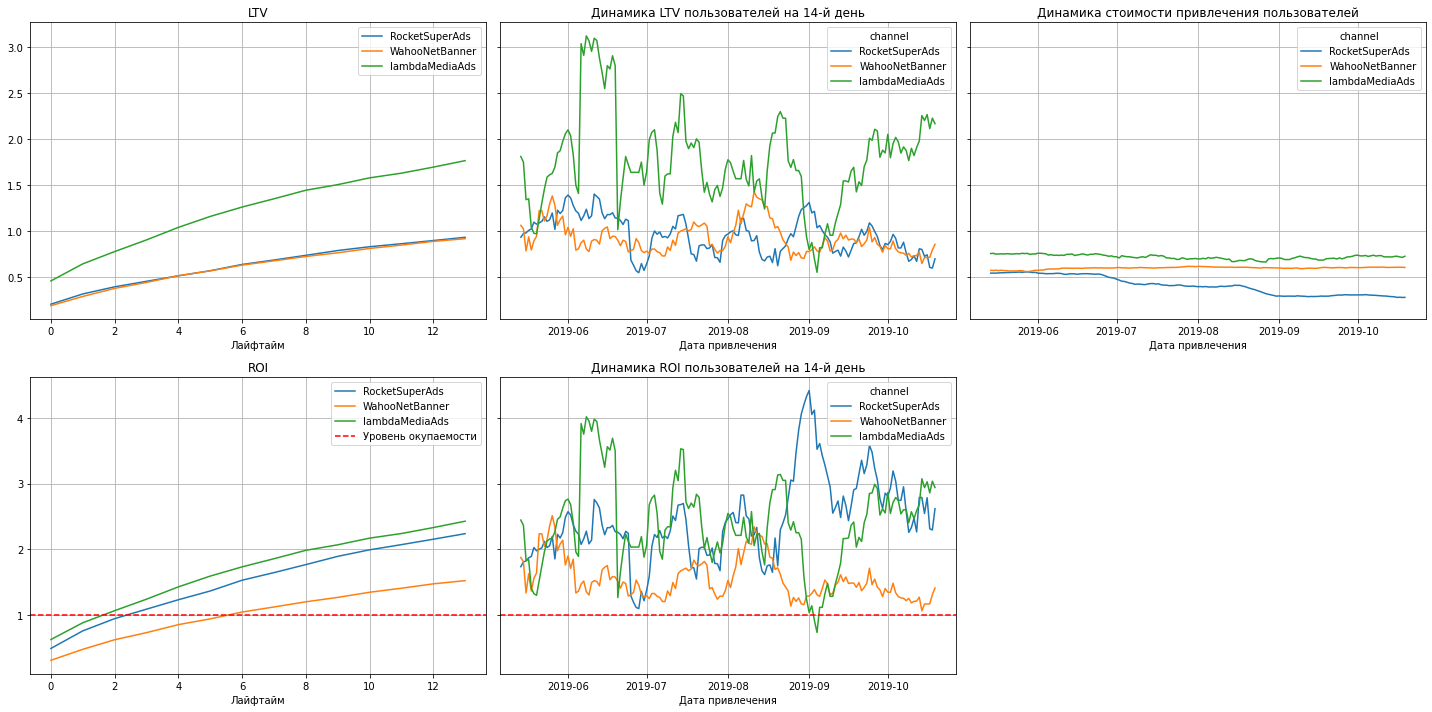

-------------------------------------------------------------------------------
Окупаемость рекламы с разбивкой по каналам привлечения группы № 3


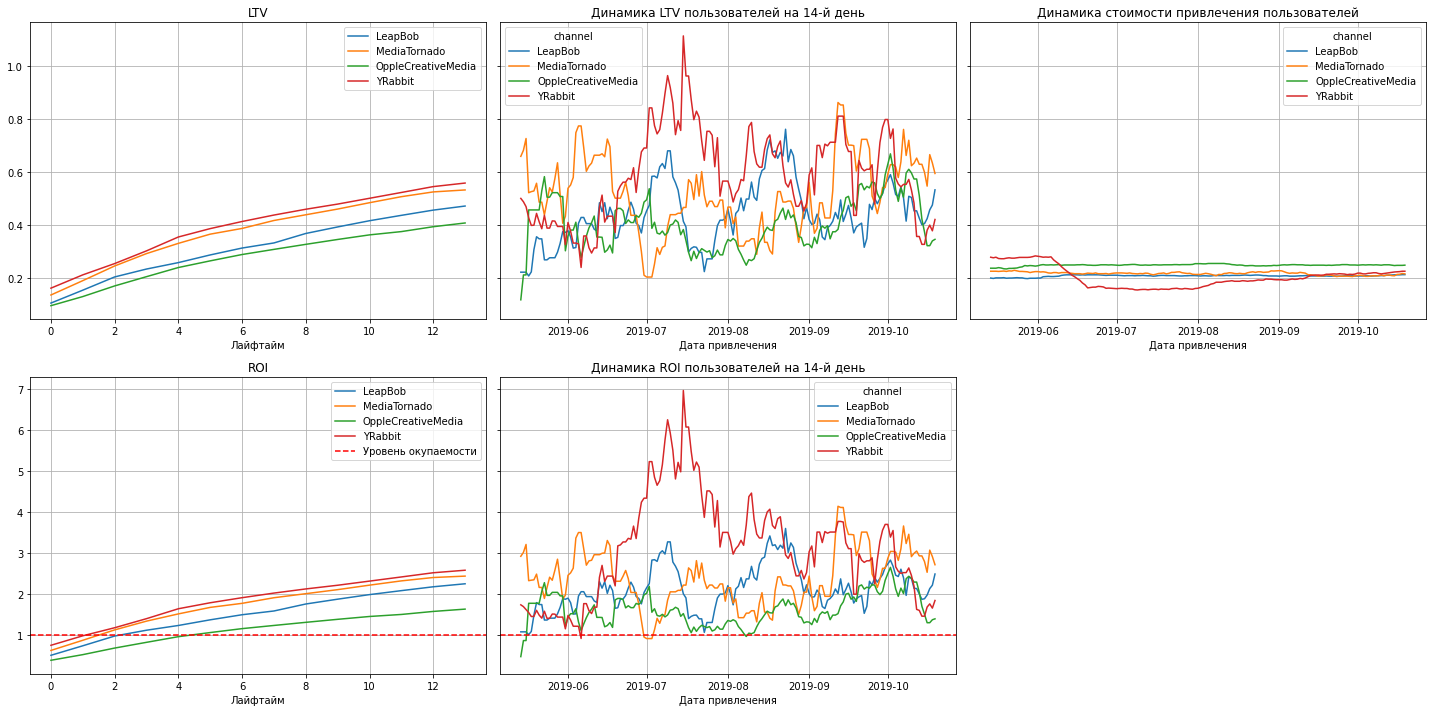

-------------------------------------------------------------------------------


In [53]:
n = 0
for filtered_profile in [filtered_1_profiles, filtered_2_profiles, filtered_3_profiles]:
    
    dimensions = ['channel']
    n += 1
    
    print('Окупаемость рекламы с разбивкой по каналам привлечения группы № {}'.format(n))
    
    ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
        filtered_profile, orders, observation_date, horizon_days, dimensions=dimensions
    )

    plot_ltv_roi(
        ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
    )
    print('-------------------------------------------------------------------------------')

Из каналов первой группы (TipTop, FaceBoom и AdNonSense), которые имеют самый большой CAC, не окупается ни один. Аудитория TipTop имеет довольно неплохой LTV на 14-й день (около 1,5 ден. ед.), однако за счёт систематически возрастающей с мая стоимости привлечения, его ROI месяц от месяца уменьшается.

Что касается канала AdNonSense: последние месяцы этот канал порой даёт ROI на 14-й день выше 100%, возможно в этом канале есть потенциал. 

У канала Faceboom стабильный CAC на протяжении всего отчётного периода, однако LTV не может превысить стоимость привлечения, и за счёт этого реклама в этом канале также не окупается.

Поэтому тот факт, что большая часть бюджета на привлечение клиентов уходит на неокупаемые каналы TipTop и FaceBoom,   вызывает вопросы. И в этом видится первая причина убытков бизнеса.

Все рекламные каналы группы №2 отлично показывают себя с точки зрения окупаемости - особенно здесь примечательны lambdaMediaAds (засчёт высокого LTV при стабильно невысоком CAC) и RocketSuperAds (засчёт снижающегося с июня CAC). Возможно на эти каналы можно выделить больше бюджета, т.к. затраты на эти источники привлечения клиентов полностью окупаются уже на 2-3 день, а на 14-й день окупаются даже на 150-250%.

Такие же сроки окупаемости показывают рекламные каналы группы № 3. В этой группе чуть хуже остальных показывает себя канал OppleCreativeMedia, однако и он выходит на окупаемость к 4-му дню, давая на 14-й день окупаемость на 150%.

### Окупаемость рекламы с разбивкой по странам

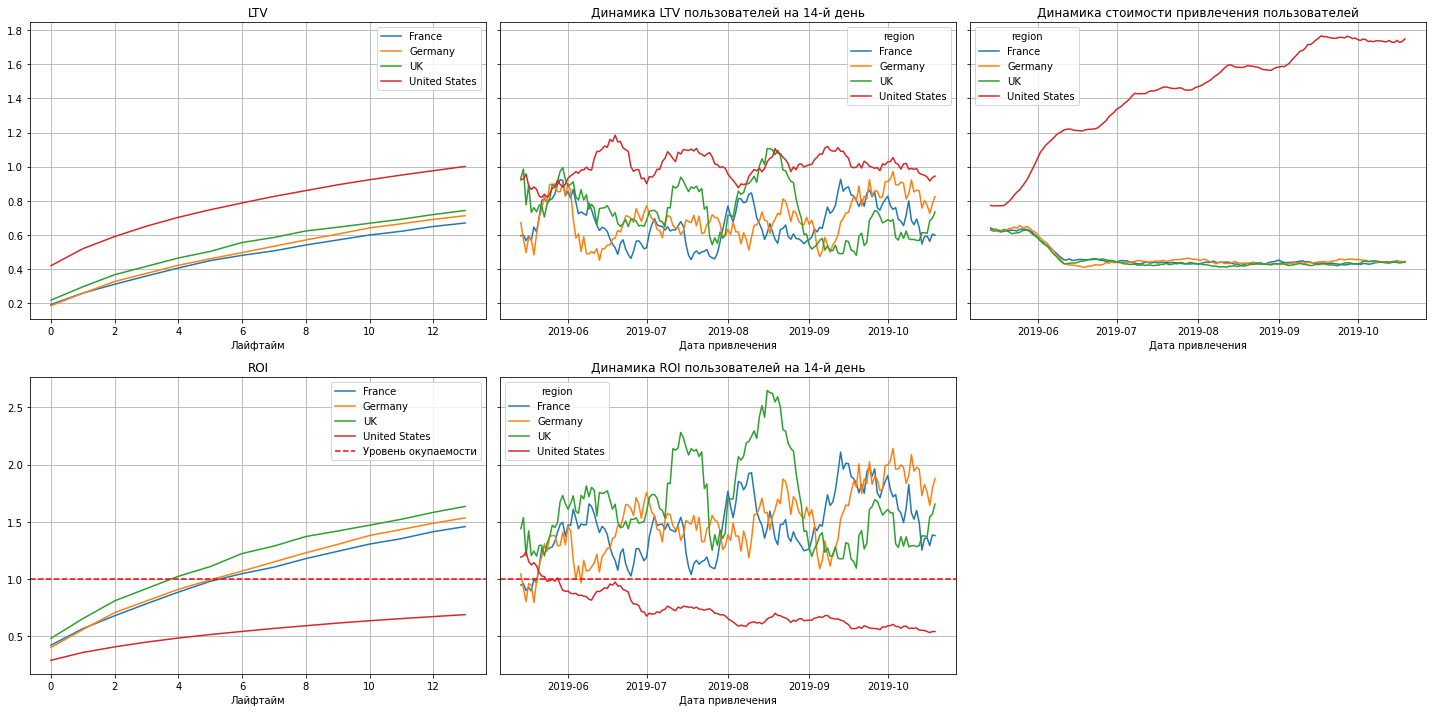

In [54]:
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

Анализ показателей по странам говорит о том, что реклама окупается во всех странах, кроме США. И это при том, что как мы помним из анализа пользовательских профилей - 2/3 всех пользователей приложения приходятся как раз таки на США, и это самая большая клиентская аудитория нашего бизнеса. Клиенты этой страны дают самый большой LTV. При этом стоимость привлечения здесь как была самой дорогой относительно других стран, так ещё и претерпела резкий скачок в июне. В других странах такого большого скачка нет.

С учётом того, что нам известно о "провальных" рекламных каналах, интересно проверить: какие каналы в каких странах используются. Посмотрим, сколько клиентов привлечено в разных странах и через какие каналы.

In [55]:
profiles.pivot_table(index='channel', columns='region', values='user_id', aggfunc='nunique').fillna(0).astype(int)

region,France,Germany,UK,United States
channel,,,,
AdNonSense,1366,1219,1295,0
FaceBoom,0,0,0,29144
LeapBob,2988,2519,3046,0
MediaTornado,0,0,0,4364
OppleCreativeMedia,2991,2562,3052,0
RocketSuperAds,0,0,0,4448
TipTop,0,0,0,19561
WahooNetBanner,2971,2579,3003,0
YRabbit,0,0,0,4312


По данным выше видно, что самая большая аудитория нашего приложения (из Штатов) во многом привлечена самыми невыгодными с точки зрения окупаемости каналами (TipTop и FaceBoom). Причём для привлечения пользователей из стран Европы бизнес пользуется совершенно другими каналами, реклама которых довольно хорошо окупается (за исключением разве что канала AdNonSense).

Стоимость привлечения через канал TipTop дорожает от месяца к месяцу, поэтому он убыточен - это было выяснено ранее. Чуть позже проверим, в чём причины низкого LTV аудитории, привлечённой через канал FaceBoom: в низкой конверсии или низком удержании.

Но перед этим проверим также окупаемость по устройствам.

### Окупаемость рекламы с разбивкой по устройствам

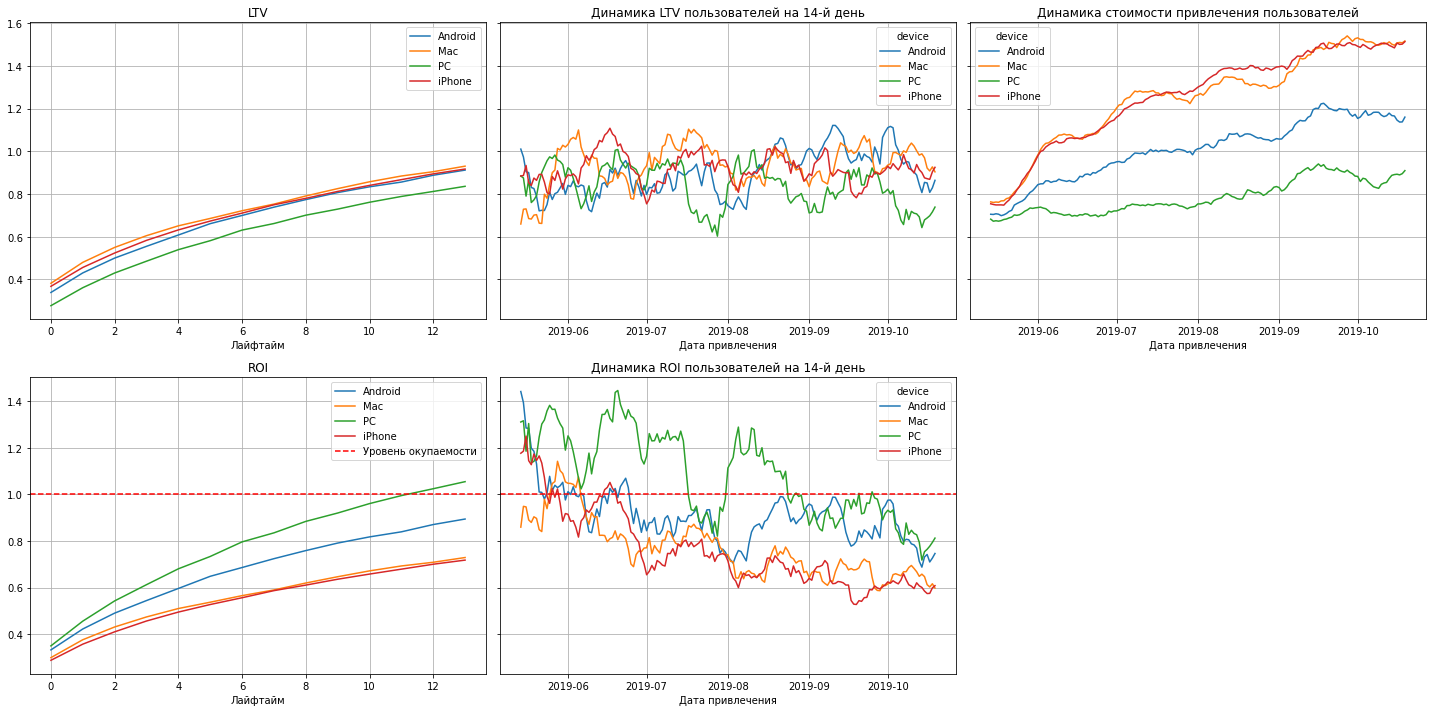

In [56]:
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

Пользователи PC до сентября как правило окупались, а вот владельцы Android, iPhone и Mac — перестали окупаться уже с июня. Но с сентября перестали окупаться даже пользователи PC, потому что в сентябре произошел ощутимый скачок в стоимости привлечения. Но самые высокие темпы роста CAC сохранялись у пользователей Iphone и Mac ещё с июня. 
Это также может быть связано с растущим СAC канала TipTop, который используется в США. А как мы видели из анализа пользовательских профилей, в Штатах 70% аудитории - это пользователи  Iphone и Mac.

Подходим к анализу конверсии и удержания для устройств iPhone и Mac (как самых популярных у наших пользователей), а также для убыточных каналов привлечения.

### Анализ конверсии и удержания с разбивкой по устройствам, cтранам, рекламным каналам

В этом разделе проанализируем конверсию и удержание с разбивкой по всем доступным характеристикам из пользовательских профилей.

#### Конверсия с разбивкой по устройствам

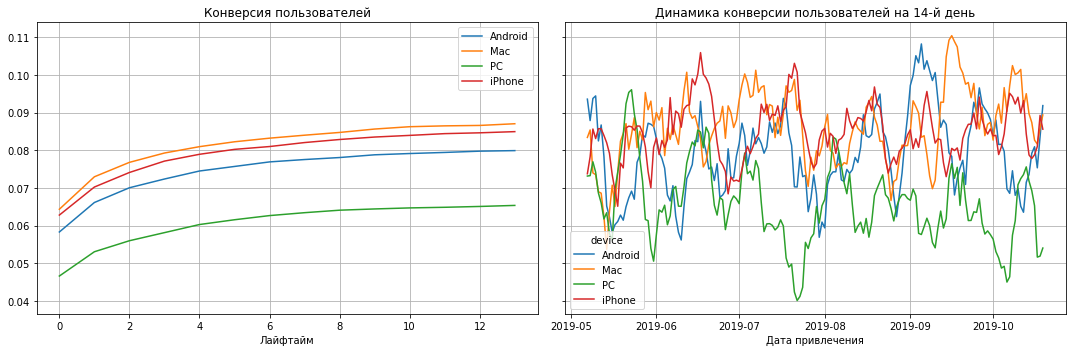

In [57]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['device']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Судя по графикам, пользователи Mac и iPhone конвертируются очень хорошо, причём довольно постоянно. Возможно, дело в удержании.

#### Удержание с разбивкой по устройствам

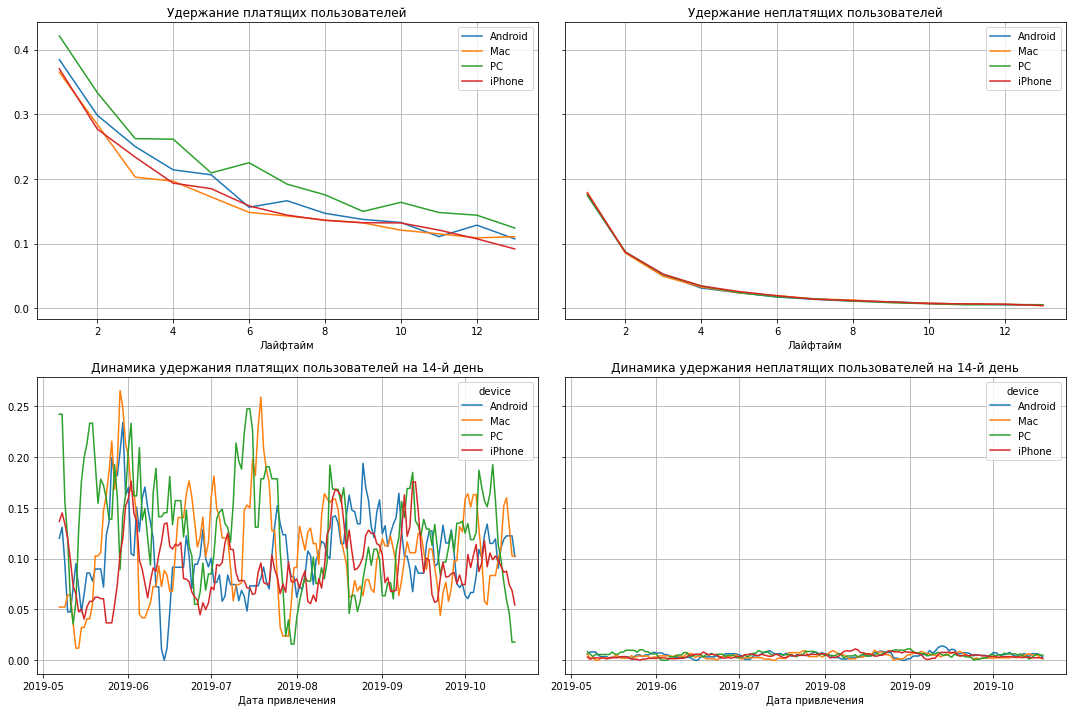

In [58]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['device']
    )

plot_retention(retention_grouped, retention_history, horizon_days)

Удержание владельцев Mac и iPhone стабильно ниже владельцев PC и Android, но не сильно остаёт. Скорее всего причина убытков кроется всё-таки в неокупаемых рекламных каналах, работающих в США.

#### Конверсия и удержание с разбивкой по каналам привлечения

Конверсия и удержание пользователей с разбивкой по каналам привлечения группы № 1


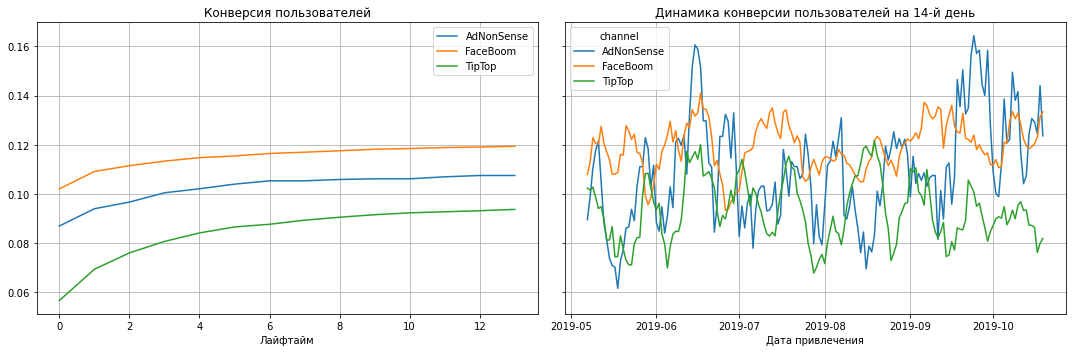

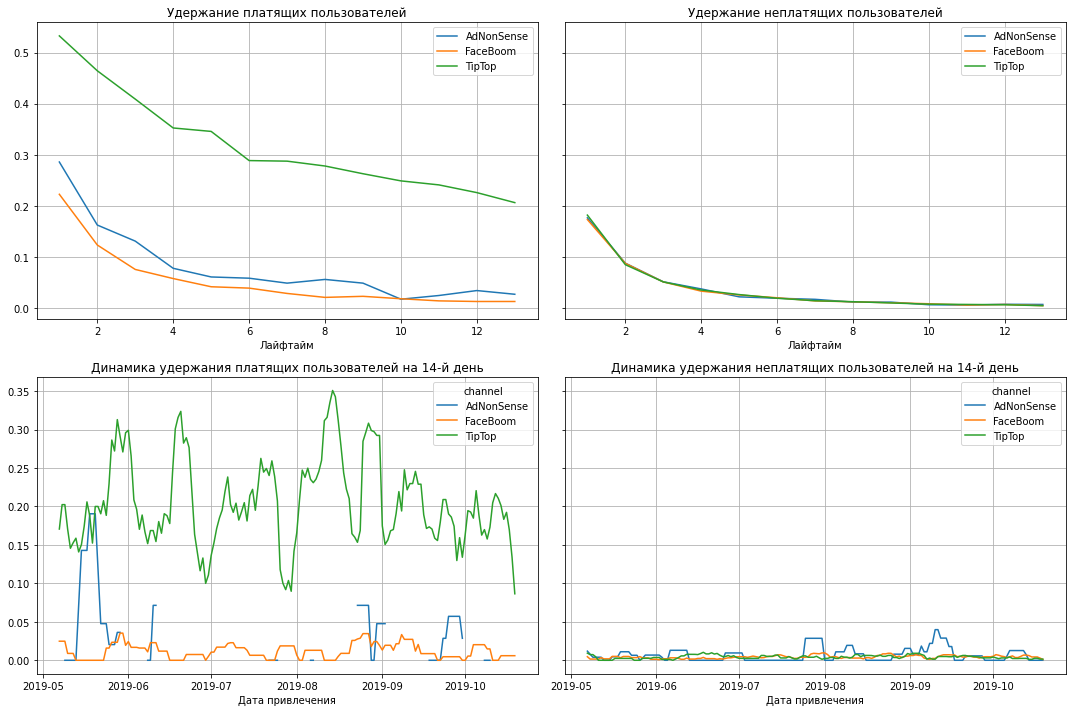

-------------------------------------------------------------------------------
Конверсия и удержание пользователей с разбивкой по каналам привлечения группы № 2


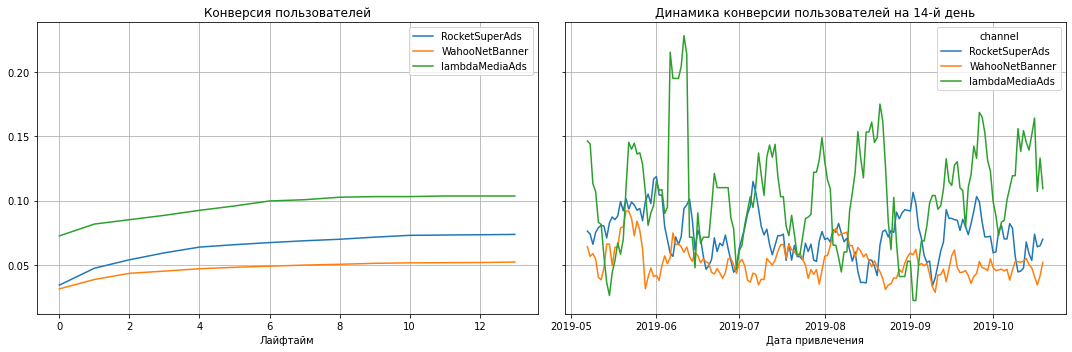

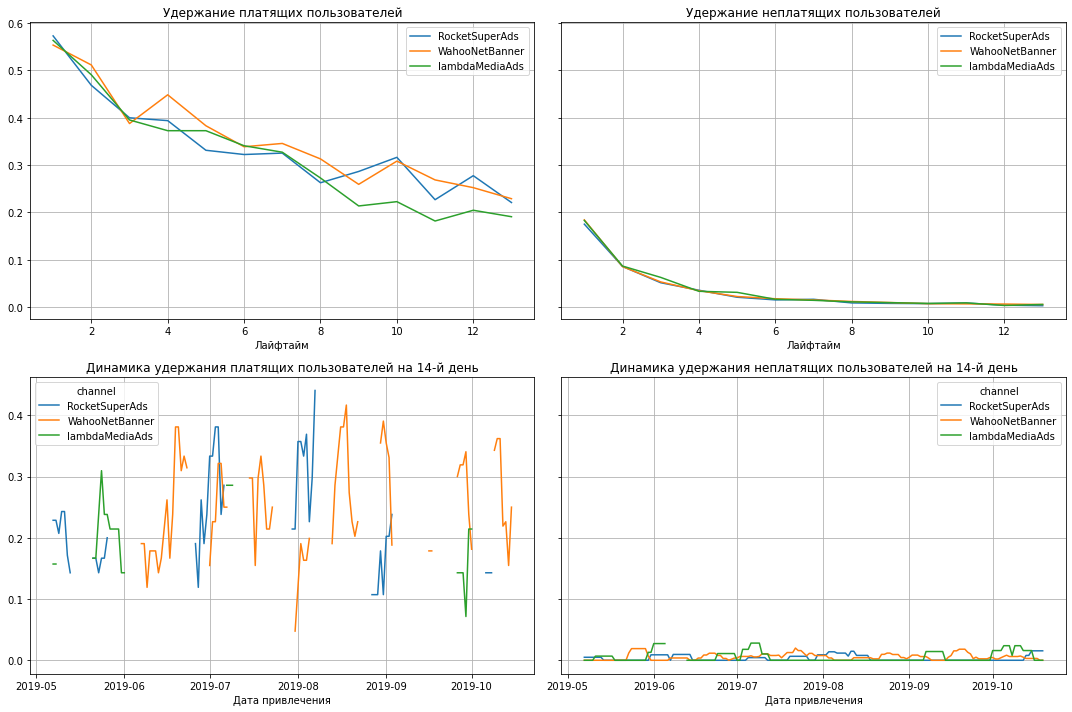

-------------------------------------------------------------------------------
Конверсия и удержание пользователей с разбивкой по каналам привлечения группы № 3


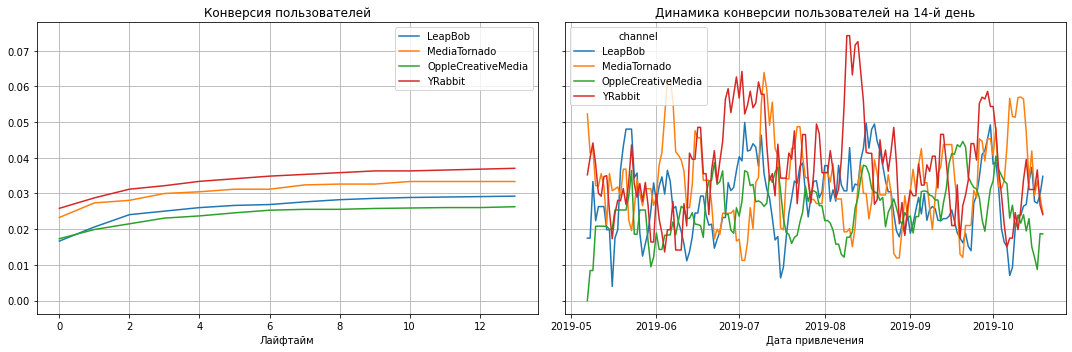

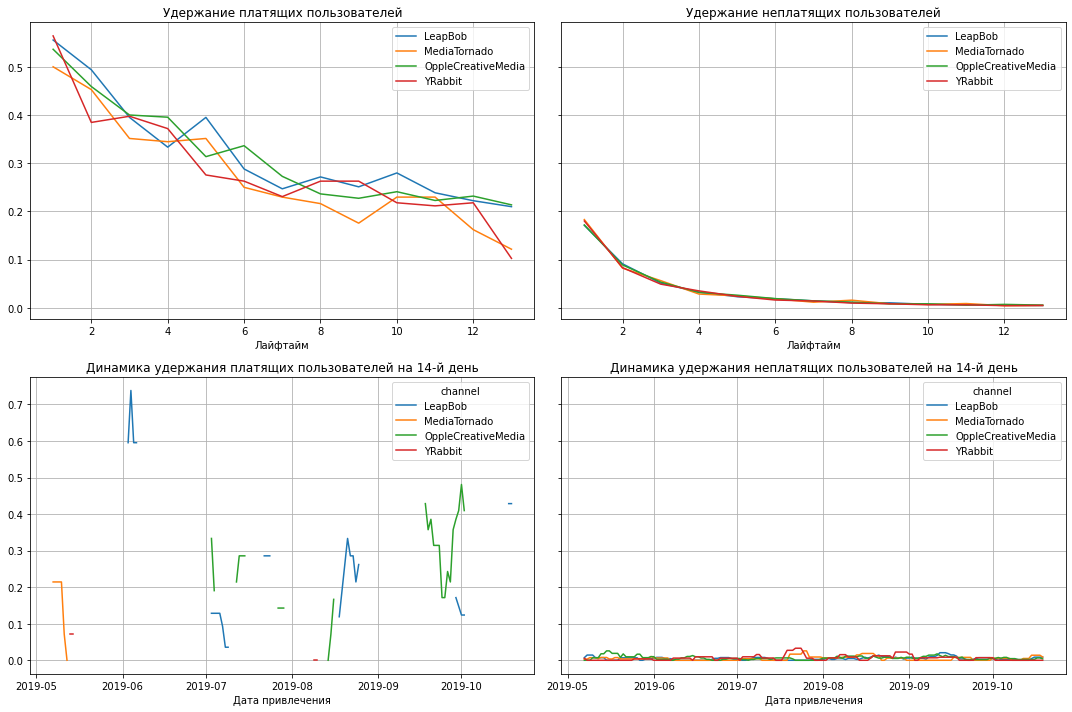

-------------------------------------------------------------------------------


In [59]:
n = 0
for filtered_profile in [filtered_1_profiles, filtered_2_profiles, filtered_3_profiles]:
    
    n += 1
    
    print('Конверсия и удержание пользователей с разбивкой по каналам привлечения группы № {}'.format(n))
    
    conversion_raw, conversion_grouped, conversion_history = get_conversion(
        filtered_profile, orders, observation_date, horizon_days, dimensions=['channel']
    )

    plot_conversion(conversion_grouped, conversion_history, horizon_days)
    
    retention_raw, retention_grouped, retention_history = get_retention(
        filtered_profile, visits, observation_date, horizon_days, dimensions=['channel']
    )

    plot_retention(retention_grouped, retention_history, horizon_days)
    
    print('-------------------------------------------------------------------------------')

Прежде всего конечно нужно обратить внимание на показатели каналов, которые не окупаются, на которые выделен большой бюджет и  которые приносят самое большое количество пользователей. Таковыми кканалами являются FaceBoom и Tiptop.

у FaceBoom  самый высокий показатель конверсии (0,12 к 14-му дню), который в среднем держится на протяжении всего отчётного периода на этом уровне довольно постоянно. При этом у него самое низкое удержание платящих пользователей, близкое к нулю на 14-й день - и это самый худший показатель среди всех каналов.

У TipTop  довольно неплохое удержание платящих пользователей и конверсия (впрочем некоторые другие каналы демонстрируют показатели получше), но из-за возрастающего CAC - реклама в этом канале не может выйти на окупаемость.

#### Конверсия и удержание с разбивкой по странам

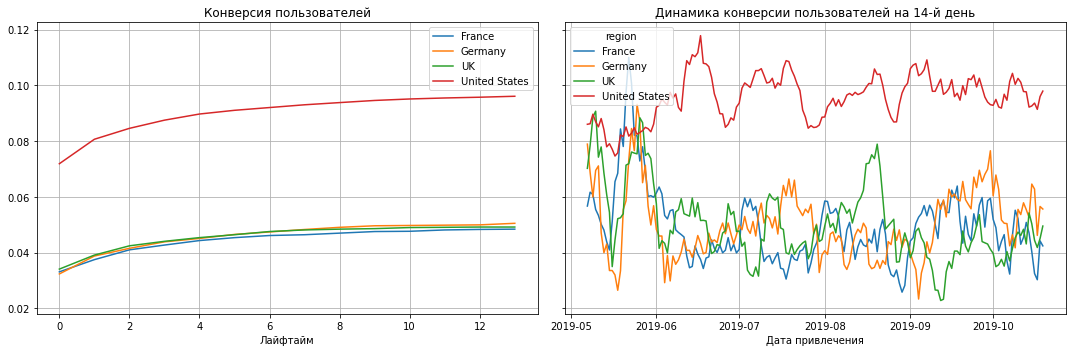

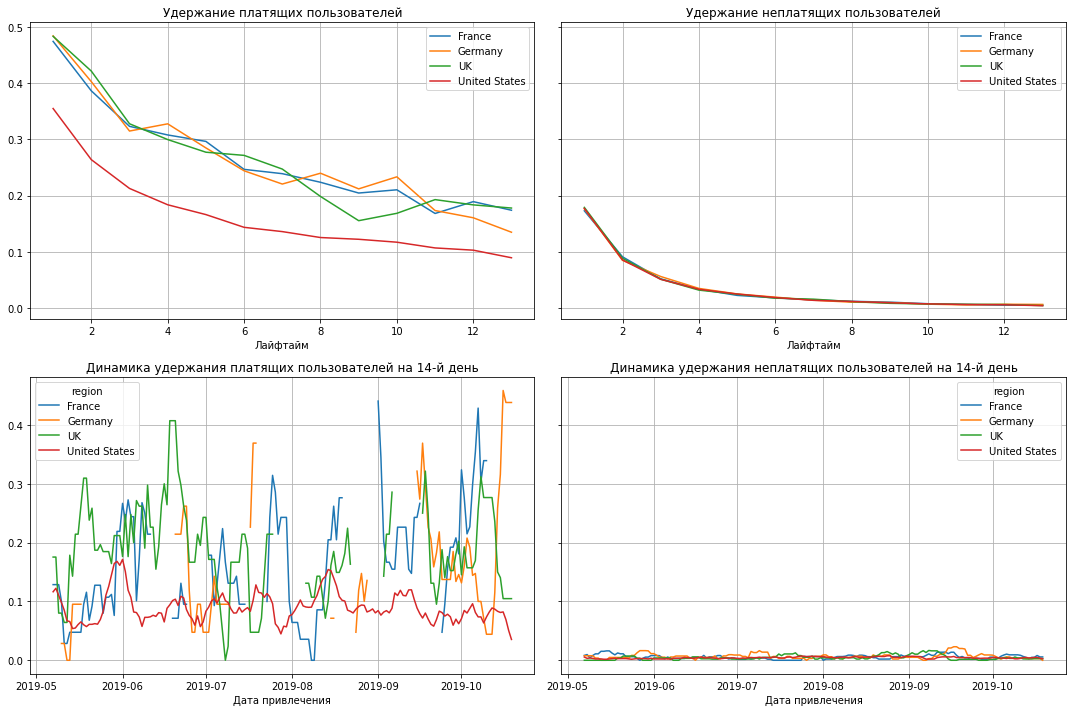

In [60]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['region']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)
    
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['region']
)

plot_retention(retention_grouped, retention_history, horizon_days)

Касательно стран, самую высокую конверсию видим в США (в среднем почти 10% на 14-й день). Страны Европы демонстрируют не сильно различающиеся относительно друг друга показатели,  демонстрируя конверсию на 14-й день в диапазоне 5%, т.е. в 2 раза меньшую по сравнению с США.

А вот удержание платящих пользователей в Штатах  всегда стабильно ниже удержания в Европе, к 14-му дню оно составляет всего 10%, тогда как в Европе аналогичный показатель от 14 до 18%.

## Выводы

### Причины неэффективности привлечения пользователей

Прежде всего, стоит отметить, что бизнес не стал привлекать меньше новых пользователей, а значит причина убытков не в этом.

При анализе было замечено, что США - это страна, которая сильно выделяется среди прочих, откуда приходят пользователи нашего приложения. Штаты - единственная страна, где реклама не окупается. При этом Штаты имеют следующие особенности:
- оттуда 2/3 пользователей приложения;
- это страна с самой большой долей платящих пользователей (7%);
- 70% пользователей из Штатов - это владельцы Iphone или Mac. Тогда как в других странах суммарная доля владельцев этих устройств только около 30%;
- самые крупные по привлечённой аудитории рекламные каналы  действуют только в США, и не действуют в остальных странах географии приложения.

Причина неэффективности привлечения пользователей кроется в том, что не окупается реклама по следующим источникам привлечения:
* TipTop
* FaceBoom
* AdNonSense

Причиной неокупаемости **источника TipTop** является систематически увеличивающаяся стоимость привлечения пользователей на 0,5 ден.ед. в месяц. Из-за этого показатель ROI этого источника с середины мая стал меньше 100% и далее только снижался.

Неокупаемость **источника FaceBoom**.
У канала Faceboom стабильный CAC на протяжении всего отчётного периода, однако LTV не может превысить стоимость привлечения, и за счёт этого реклама в этом канале также не окупается. Анализ конверсии и удержания пользователей, привлечённых через FaceBoom, показал, что у этого источника самое низкое удержание платящих пользователей, близкое к нулю на 14-й день - и это самый худший показатель среди всех каналов.


### Рекомендации для повышения эффективности

Для повышения эффективности привлечения пользователей необходимо пересмотреть структуру маркетинговых затрат по источникам привлечения:  отказаться от убыточных (неокупаемых TipTop, FaceBoom и AdNonSense), а высвобожденные средства потратить на другие, более эффективные источники привлечения.

Самые эффективные источники в США, куда можно привлечь больше средств:
* YRabbit - его ROI на 14-й день 260%.
* MediaTornado  - ROI на 14-й день  250%.

Самый эффективный источник в странах Европы, куда можно привлечь больше средств:
* LeapBob - его ROI на 14-й день 230%.